<a href="https://colab.research.google.com/github/StergiousAji/DL-Coursework-24_damages/blob/main/DL_Coursework_24_damages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Damages - Deep Learning Coursework 2024

The aim of this coursework will be for you to design, implement and test a deep learning architecture to detect and identify damage in images. Digitization allows to make historical pictures and art much more widely available to the public. Many such pictures have suffered some form of damage due to time, storage conditions and the fragility of the original medium. For example, the image below (A) shows an example of a digitized parchment that has suffered significant damage over time.

**The aim of this project is for you to design, implement and evaluate a deep learning model to detect and identify damage present in images.**

<table>
<tr>
<td>
<div>
<img src="damage_data/image_path/cljmrkz5n341f07clcujw105j.png" width="500"/>
</div>
</td>
<td>
<div>
<img src="damage_data/annotation_rgb_path/cljmrkz5n341f07clcujw105j.png" width="500"/>
</div>
</td>
</tr>
<td><center>(A) Image</center></td><td><center>(B) damage labels</center></td>
</table>
*(Note that the images will only show once you have downloaded the dataset)*


The image labels in this figure (B) identifies a smatter of peeling paint, a large stained area in the bottom left and a missing part on the top left. Each colour in those images corresponds to a different category of damage, including `fold`, `writing` or `burn marks`. You are provided with a dataset of a variety of damaged images, from Parchment to ceramic or wood painting, and detailed annotations of a range of damages.

You are free to use any architecture you prefer, from what we have seen in class. You can decide to use unsupervised pre-training of only supervised end-to-end training - the approach you choose is your choice.

### Hand-in date: Friday 15th of March before 4:30pm (on Moodle)

### Steps & Hints
* First, look at the data. What are the different type of images (content), what type of material, what type of damage? How different are they? What type of transformations for your data augmentation do you think would be acceptable here?.
* Second, check the provided helper functions for loading the data and separate into training and test set and cross-validation.
* Design a network for the task. What output? What layers? How many? Do you want to use an Autoencoder for unsupervised pre-training?
* Choose a loss function for your network
* Select optimiser and training parameters (batch size, learning rate)
* Optimise your model, and tune hyperparameters (especially learning rate, momentum etc)
* Analyse the results on the test data. How to measure success? Which classes are recognised well, which are not? Is there confusion between some classes? Look at failure cases.
* If time allows, go back to drawing board and try a more complex, or better, model.
* Explain your thought process, justify your choices and discuss the results!

### Submission
* submit ONE zip file on Moodle containing:
  * **your notebook**: use `File -> download .ipynb` to download the notebook file locally from colab.
  * **a PDF file** of your notebook's output as you see it: use `File -> print` to generate a PDF.
* your notebook must clearly contains separate cells for:
  * setting up your model and data loader
  * training your model from data
  * loading your pretrained model from github/gitlab/any other online storage you like!
  * testing your model on test data.
* The training cells must be disabled by a flag, such that when running *run all* on your notebook it does
  * load the data
  * load your model
  * apply the model to the test data
  * analyse and display the results and accuracy
* In addition provide markup cell:
  * containing your student number at the top
  * to describe and motivate your design choices: architecture, pre-processing, training regime
  * to analyse, describe and comment on your results
  * to provide some discussion on what you think are the limitations of your solution and what could be future work

* **Note that you must put your trained model online so that your code can download it.**


### Assessment criteria
* In order to get a pass mark, you will need to demonstrate that you have designed and trained a deep NN to solve the problem, using sensible approach and reasonable efforts to tune hyper-parameters. You have analysed the results. It is NOT necessary to have any level of accuracy (a network that predicts poorly will always yield a pass mark if it is designed, tuned and analysed sensibly).
* In order to get a good mark, you will show good understanding of the approach and provide a working solution.
* in order to get a high mark, you will demonstrate a working approach of gradual improvement between different versions of your solution.
* bonus marks for attempting something original if well motivated - even if it does not yield increased performance.
* bonus marks for getting high performance, and some more points are to grab for getting the best performance in the class.

### Notes
* You are provided code to isolate the test set and cross validation, make sure to keep the separation clean to ensure proper setting of all hyperparameters.
* I recommend to start with small models that can be easier to train to set a baseline performance before attempting more complex one.
* Be mindful of the time!

## Housekeeping

In [ ]:
!pip install gdown pytorch_lightning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import os
import pandas as pd
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 243748701
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import gdown
import shutil

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

# NOTEBOOK FLAGS AND VARIABLES
DOWNLOAD = False
VISUALISE = False
BATCH_SIZE = 4
TRAIN = True

cuda:0


# Load dataset

We then load the metadata in a dataframe for convenience

In [4]:
# Damages dataset mounted to Google Drive so disable download
if DOWNLOAD:
    !gdown 1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS -O damages.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# set  that to wherever you want to store the data (eg, your Google Drive), choose a persistent location!
# root_dir = '/content/drive/MyDrive/'
root_dir = "./"
data_dir = os.path.join(root_dir, "damage_data")
csv_path = os.path.join(data_dir, 'metadata.csv')

try:
    df = pd.read_csv(csv_path)

except:  # if the dataset has not been downloaded yet, do it.
    zip_path = os.path.join(root_dir, 'damages.zip')
    gdown.download(id='1v8aUId0-tTW3ln3O2BE4XajQeCToOEiS', output=zip_path)
    shutil.unpack_archive(zip_path, root_dir)
    df = pd.read_csv(csv_path)

This dataframe has the paths of where the dataset images and annotation labels are stored, plus classification labels.

In [7]:
df

id   material             content  \
0    cljmrkz5n341f07clcujw105j  Parchment  Artistic depiction   
1    cljmrkz5n341n07clf1u410ed  Parchment  Artistic depiction   
2    cljmrkz5n341r07clhl93dpre  Parchment  Artistic depiction   
3    cljmrkz5n341v07cl2gfhd6zj  Parchment  Artistic depiction   
4    cljmrkz5n341z07cldbn01un3  Parchment  Artistic depiction   
..                         ...        ...                 ...   
390  clnofow7i00n2076ubpfodf4d       Wood  Artistic depiction   
391  clnrm7fvu092q07840tq9zs03       Wood  Artistic depiction   
392  clnrm7fvu092r0784a6p2m5li       Wood  Artistic depiction   
393  clnrm7fvu092s0784tgwccewe       Wood  Artistic depiction   
394  clnrm7fvu092t0784ltljhiu0       Wood  Artistic depiction   

                                            image_path  \
0    ./damage_data/image_path/cljmrkz5n341f07clcujw...   
1    ./damage_data/image_path/cljmrkz5n341n07clf1u4...   
2    ./damage_data/image_path/cljmrkz5n341r07clhl93...   
3    ./damage_data/image_path/cljmrkz5n341v07cl2gfh...   
4    ./damage_data/image_path/cljmrkz5n341z07cldbn0...   
..                                                 ...   
390  ./damage_data/image_path/clnofow7i00n2076ubpfo...   
391  ./damage_data/image_path/clnrm7fvu092q07840tq9...   
392  ./damage_data/image_path/clnrm7fvu092r0784a6p2...   
393  ./damage_data/image_path/clnrm7fvu092s0784tgwc...   
394  ./damage_data/image_path/clnrm7fvu092t0784ltlj...   

                                       annotation_path  \
0    ./damage_data/annotation_path/cljmrkz5n341f07c...   
1    ./damage_data/annotation_path/cljmrkz5n341n07c...   
2    ./damage_data/annotation_path/cljmrkz5n341r07c...   
3    ./damage_data/annotation_path/cljmrkz5n341v07c...   
4    ./damage_data/annotation_path/cljmrkz5n341z07c...   
..                                                 ...   
390  ./damage_data/annotation_path/clnofow7i00n2076...   
391  ./damage_data/annotation_path/clnrm7fvu092q078...   
392  ./damage_data/annotation_path/clnrm7fvu092r078...   
393  ./damage_data/annotation_path/clnrm7fvu092s078...   
394  ./damage_data/annotation_path/clnrm7fvu092t078...   

                                   annotation_rgb_path  
0    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
1    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
2    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
3    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
4    ./damage_data/annotation_rgb_path/cljmrkz5n341...  
..                                                 ...  
390  ./damage_data/annotation_rgb_path/clnofow7i00n...  
391  ./damage_data/annotation_rgb_path/clnrm7fvu092...  
392  ./damage_data/annotation_rgb_path/clnrm7fvu092...  
393  ./damage_data/annotation_rgb_path/clnrm7fvu092...  
394  ./damage_data/annotation_rgb_path/clnrm7fvu092...  

[395 rows x 6 columns]

### Distribution of Damages by Material

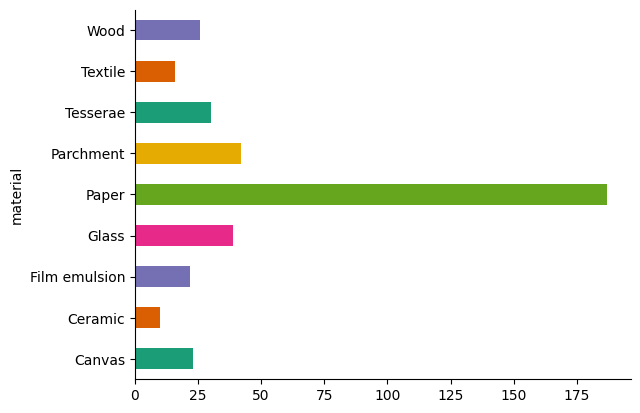

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('material').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

The images in the dataset are categorised in terms of the type of `material`, meaning what was the original picture on, eg, Parchment, Glass or Textile.

In [ ]:
df['material'].unique()

array(['Parchment', 'Film emulsion', 'Glass', 'Paper', 'Tesserae',
       'Canvas', 'Textile', 'Ceramic', 'Wood'], dtype=object)

Moreover, images are also categorised in terms on the `content` of the image, meaning what is depicted: eg, Line art, geometric patterns, etc.

In [ ]:
df['content'].unique()

array(['Artistic depiction', 'Line art', 'Photographic depiction',
       'Geometric patterns'], dtype=object)

## Labels
Segmentation labels are saved as a PNG image, where each number from 1 to 15 corresponds to a damage class like Peel, Scratch etc; the Background class is set to 255, and the Clean class (no damage) is set to 0. We also provide code to convert these annotation values to RGB colours for nicer visualisation, but for training you should use the original annotations.

In [8]:
name_color_mapping = {
    "Material loss": "#1CE6FF",
    "Peel": "#FF34FF",
    "Dust": "#FF4A46",
    "Scratch": "#008941",
    "Hair": "#006FA6",
    "Dirt": "#A30059",
    "Fold": "#FFA500",
    "Writing": "#7A4900",
    "Cracks": "#0000A6",
    "Staining": "#63FFAC",
    "Stamp": "#004D43",
    "Sticker": "#8FB0FF",
    "Puncture": "#997D87",
    "Background": "#5A0007",
    "Burn marks": "#809693",
    "Lightleak": "#f6ff1b",
}

class_names = [ 'Material loss', 'Peel', 'Dust', 'Scratch',
                'Hair', 'Dirt', 'Fold', 'Writing', 'Cracks', 'Staining', 'Stamp',
                'Sticker', 'Puncture', 'Burn marks', 'Lightleak', 'Background']

class_to_id = {class_name: idx+1 for idx, class_name in enumerate(class_names)}
class_to_id['Background'] = 255  # Set the Background ID to 255

def hex_to_rgb(hex_color: str) -> tuple:
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

id_to_rgb = {class_to_id[class_name]: hex_to_rgb(color) for class_name, color in name_color_mapping.items()}
id_to_rgb[0] = (0,0,0)

# Create id2label mapping: ID to class name
id2label = {idx: class_name for class_name, idx in class_to_id.items()}

# Create label2id mapping: class name to ID, which is the same as class_to_id
label2id = class_to_id

# Non-damaged pixels
id2label[0] = 'Clean'
label2id['Clean'] = 0

In [9]:
from IPython.display import Markdown

legend='#### Colour labels for each damage type\n'
for damage in class_names:
    legend += '- <span style="color: {color}">{damage}</span>.\n'.format(color=name_color_mapping[damage], damage=damage)
display(Markdown(legend))

#### Colour labels for each damage type
- <span style="color: #1CE6FF">Material loss</span>.
- <span style="color: #FF34FF">Peel</span>.
- <span style="color: #FF4A46">Dust</span>.
- <span style="color: #008941">Scratch</span>.
- <span style="color: #006FA6">Hair</span>.
- <span style="color: #A30059">Dirt</span>.
- <span style="color: #FFA500">Fold</span>.
- <span style="color: #7A4900">Writing</span>.
- <span style="color: #0000A6">Cracks</span>.
- <span style="color: #63FFAC">Staining</span>.
- <span style="color: #004D43">Stamp</span>.
- <span style="color: #8FB0FF">Sticker</span>.
- <span style="color: #997D87">Puncture</span>.
- <span style="color: #809693">Burn marks</span>.
- <span style="color: #f6ff1b">Lightleak</span>.
- <span style="color: #5A0007">Background</span>.


## Create dataset splits

Here is an example of how to split the dataset for Leave-one-out cross validation (LOOCV) based on material.

In [3]:
def create_leave_one_out_splits(df, criterion='material'):
    grouped = df.groupby(criterion)
    content_splits = {name: group for name, group in grouped}
    unique_val = df[criterion].unique()

    # Initialize a dictionary to hold the train and validation sets for each LOOCV iteration
    loocv_splits = {}

    for value in unique_val:
        # Create the validation set
        val_set = content_splits[value]

        # Create the training set
        train_set = pd.concat([content_splits[c] for c in unique_val if c != value])

        # Add these to the loocv_splits dictionary
        loocv_splits[value] = {'train_set': train_set, 'val_set': val_set}

    return loocv_splits

For this coursework, we will want to assess the generalisation of the method, so for that we will keep one type of material (`Canvas`) as test set, and only train on the remaining ones.

In [4]:
# split the dataset according to material type

full_splits = create_leave_one_out_splits(df, 'material')

# use Canvas as test set
test_set = full_splits['Canvas']['val_set']

# use the rest as training set
train_set = full_splits['Canvas']['train_set']

# prepare a leave-one-out cross validation for the training set
loocv_splits = create_leave_one_out_splits(train_set, 'material')

# identify the different type of image content
unique_material = train_set['material'].unique()
print(unique_material)


['Parchment' 'Film emulsion' 'Glass' 'Paper' 'Tesserae' 'Textile'
 'Ceramic' 'Wood']


To help you, here are some helper functions to help crop and process images.

In [5]:
def random_square_crop_params(image, target_size):
    width, height = image.size
    min_edge = min(width, height)

    # Conditionally set the range for random crop size
    lower_bound = min(min_edge, target_size)
    upper_bound = max(min_edge, target_size)

    # Generate crop_size
    crop_size = random.randint(lower_bound, upper_bound)

    # Check and adjust if crop_size is larger than any dimension of the image
    if crop_size > width or crop_size > height:
        crop_size = min(width, height)

    # Generate random coordinates for the top-left corner of the crop
    x = random.randint(0, width - crop_size)
    y = random.randint(0, height - crop_size)

    return (x, y, x + crop_size, y + crop_size)

def apply_crop_and_resize(image, coords, target_size):
    image_crop = image.crop(coords)
    image_crop = image_crop.resize((target_size, target_size), Image.NEAREST)
    return image_crop

We also provide a simple class for holding the dataset

In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import random
import numpy as np
from PIL import Image

from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_size, is_train=True):
        self.dataframe = dataframe
        self.target_size = target_size
        self.is_train = is_train

        self.to_tensor = transforms.ToTensor()

        # Define the normalization transform
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
            return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(root_dir + row['image_path']).convert('RGB')
        annotation = Image.open(root_dir + row['annotation_path']).convert('L')
        annotation_rgb = Image.open(root_dir + row['annotation_rgb_path']).convert('RGB')
        id = row['id']
        material = row['material']
        content = row['content']

        if self.is_train:
            # Generate random square cropping coordinates
            crop_coords = random_square_crop_params(image, self.target_size)

            # Apply the same cropping and resizing to all
            image = apply_crop_and_resize(image, crop_coords, self.target_size)
            annotation = apply_crop_and_resize(annotation, crop_coords, self.target_size)
            annotation_rgb = apply_crop_and_resize(annotation_rgb, crop_coords, self.target_size)
        else:  # Validation
            # Instead of cropping, downsize the images so that the longest edge is 1024 or less
            max_edge = max(image.size)
            if max_edge > 1024:
                downsample_ratio = 1024 / max_edge
                new_size = tuple([int(dim * downsample_ratio) for dim in image.size])

                image = image.resize(new_size, Image.BILINEAR)
                annotation = annotation.resize(new_size, Image.NEAREST)
                annotation_rgb = annotation_rgb.resize(new_size, Image.BILINEAR)

        # Convert PIL images to PyTorch tensors
        image = self.to_tensor(image)
        annotation = torch.tensor(np.array(annotation), dtype=torch.long)
        annotation_rgb = self.to_tensor(annotation_rgb)

        # Normalize the image
        image = self.normalize(image)

        # Change all values in annotation that are 255 to 16
        annotation[annotation == 255] = 16

        return {
            'image': image,
            'annotation': annotation,
            'annotation_rgb': annotation_rgb,
            'id': id,
            'material': material,
            'content': content
        }

Here we create a DataModule which encapsulates our training and validation DataLoaders; you can also do this manually by only using the Pytorch DataLoader class, lines 24 and 27.

In [7]:
from torch.utils.data import DataLoader

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, loocv_splits, current_material, target_size, batch_size=32, num_workers=4):
        super().__init__()
        self.loocv_splits = loocv_splits
        self.current_material = current_material
        self.target_size = target_size
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        # Load current train and validation set based on LOOCV iteration
        train_df = self.loocv_splits[self.current_material]['train_set']
        val_df = self.loocv_splits[self.current_material]['val_set'].sample(frac=1).reset_index(drop=True)

        self.train_dataset = CustomDataset(dataframe=train_df, target_size=self.target_size, is_train=True)
        self.val_dataset = CustomDataset(dataframe=val_df, target_size=self.target_size, is_train=False)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=1, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        pass


The following will create a data module for validating on the first content in the list (`Parchment`) and training on all the other types of material (you will want to do that for each fold).

In [8]:
data_module = CustomDataModule(loocv_splits=loocv_splits,
                               current_material=unique_material[0],
                               target_size=512,
                               batch_size=BATCH_SIZE, 
                               num_workers=0)

Finally, we can get the train and validation data loaders from the data module.

In [9]:
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

# Dataset visualisation

We need to denormalise the images so we can display them

In [10]:
# Mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(image, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    img_cpy = image.copy()
    for i in range(3):
        img_cpy[..., i] = img_cpy[..., i] * std[i] + mean[i]
    return img_cpy

## Visualise training samples
Random square crops of the images and correspoding RGB annotations on their own and overlaid onto the image.

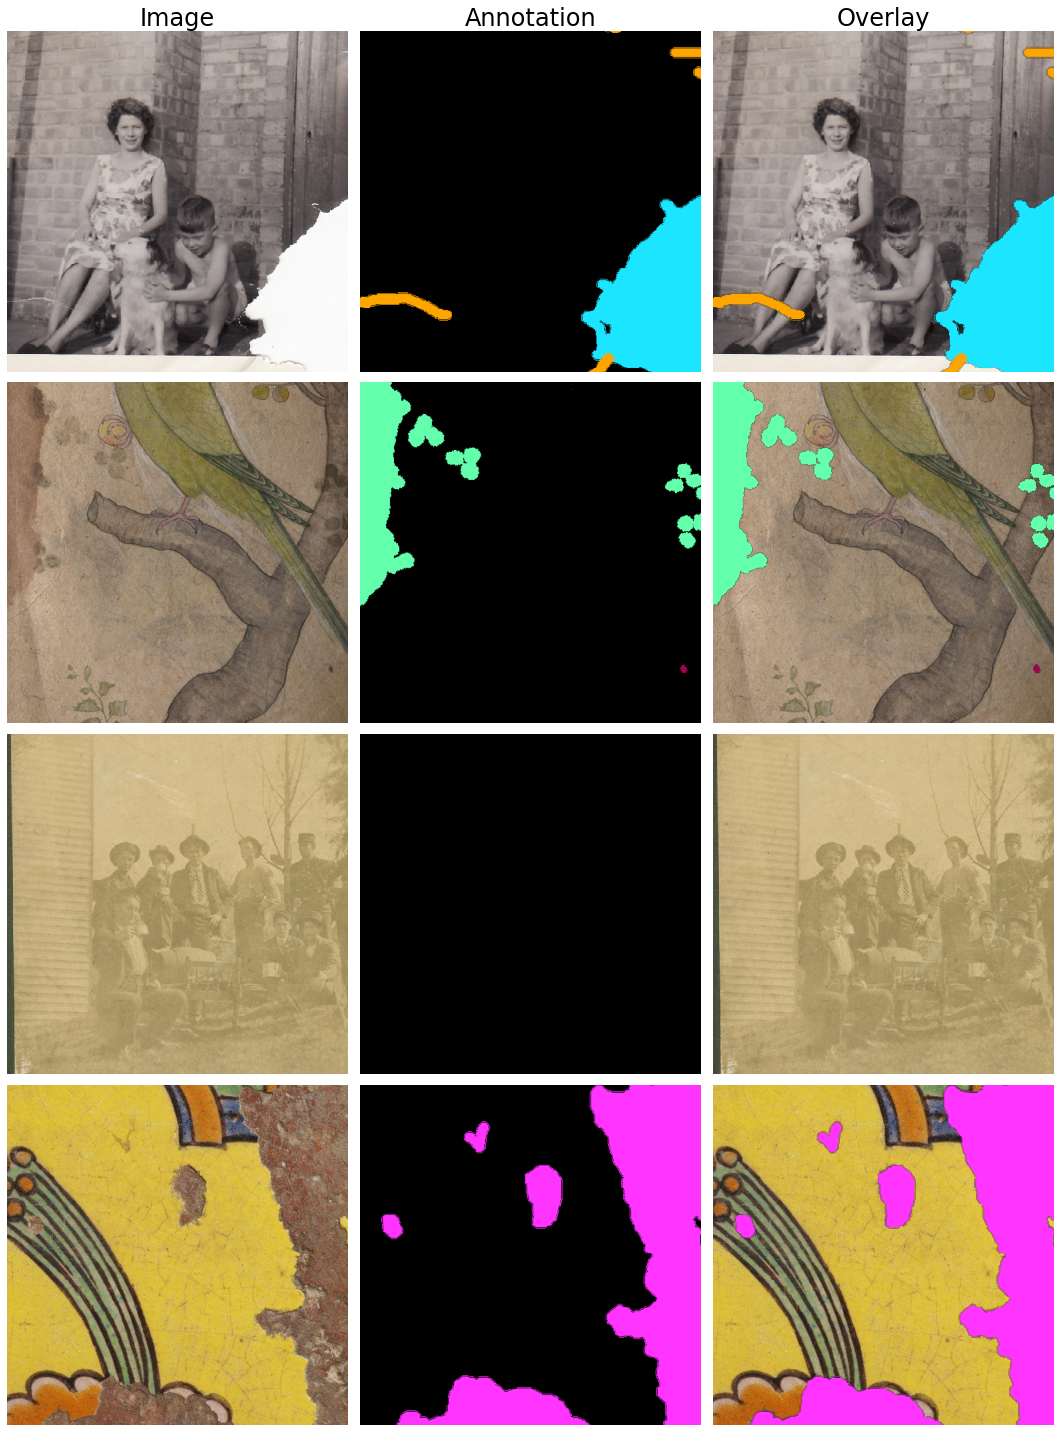

In [11]:
if VISUALISE:
    example_batch = next(iter(train_loader))
    example_images = example_batch['image']
    example_annotations = example_batch['annotation']
    example_annotation_rgbs = example_batch['annotation_rgb']

    # Number of examples to visualize
    N = min(4, len(example_images))

    fig, axes = plt.subplots(N, 3, figsize=(15, 5 * N))

    for ax, col in zip(axes[0], ['Image', 'Annotation', 'Overlay']):
        ax.set_title(col, fontsize=24)

    for i in range(N):
        example_image = denormalize(example_images[i].numpy().transpose((1, 2, 0)), mean, std)  # C, H, W -> H, W, C
        example_annotation = Image.fromarray(np.uint8(example_annotations[i].numpy()), 'L')
        example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C

        # Create an alpha (transparency) channel where black pixels in annotation_rgb are fully transparent
        alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
        example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))

        axes[i, 0].imshow(example_image)
        axes[i, 0].axis('off')

        # axes[i, 1].imshow(example_annotation, cmap='gray', vmin=0, vmax=255)
        axes[i, 1].imshow(example_annotation_rgb)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(example_image)
        axes[i, 2].imshow(example_annotation_rgba)
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

Visualising the validation set, which loads the left-out class as whole images.

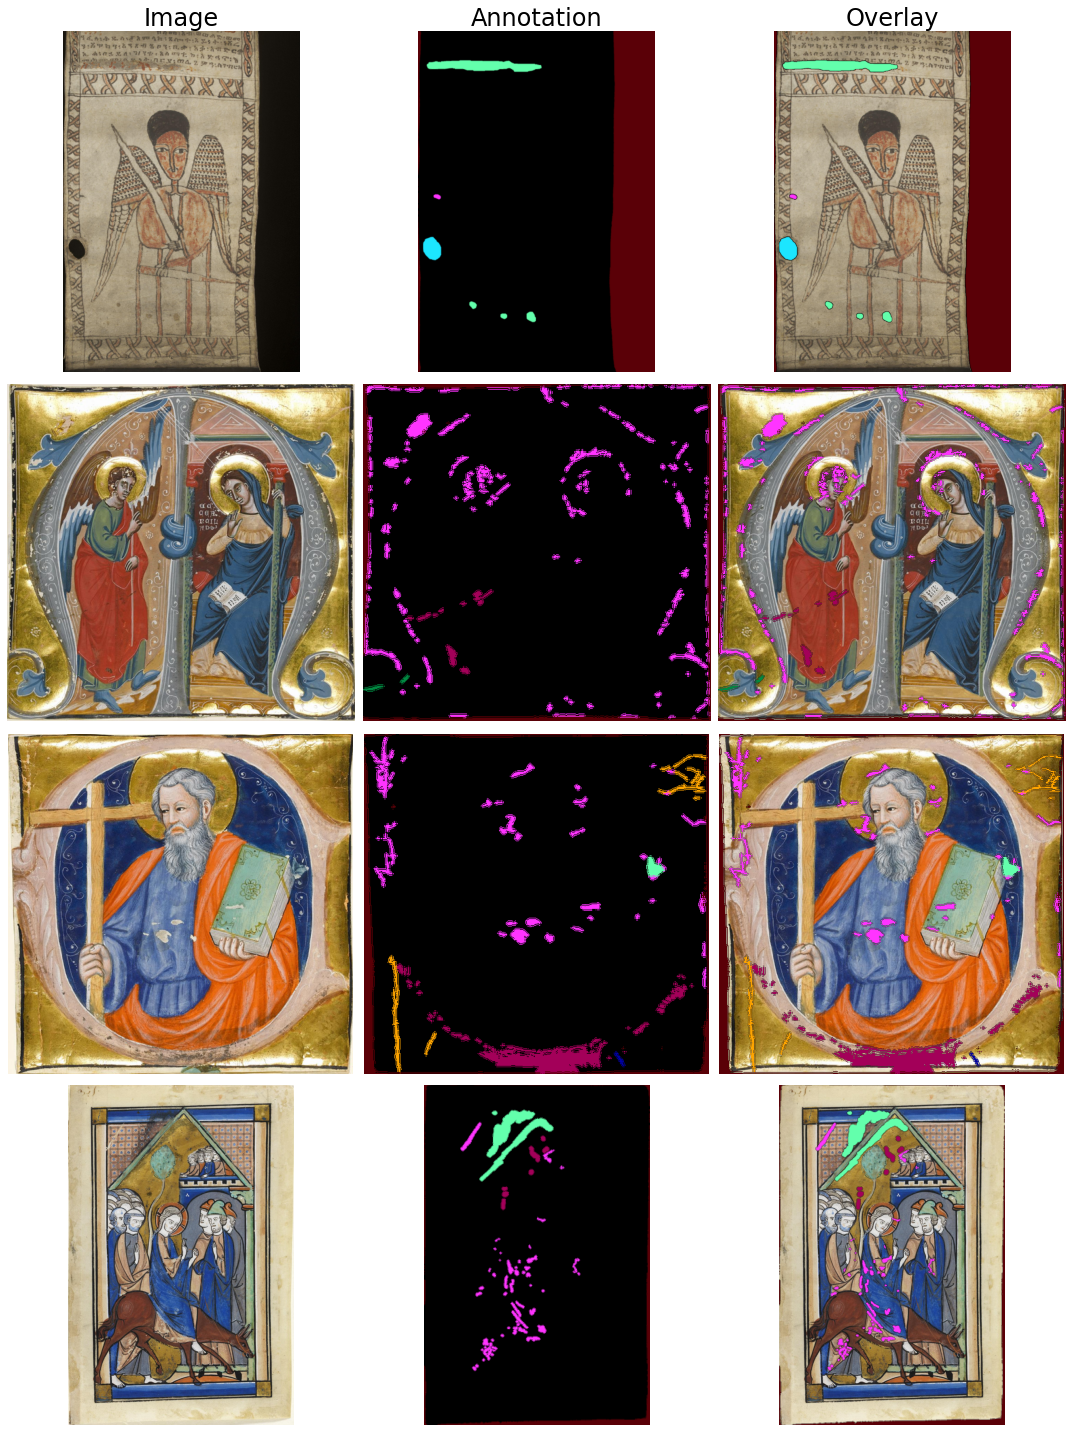

In [12]:
if VISUALISE:
    val_iter = iter(val_loader)
    example_batches = [next(val_iter) for _ in range(4)]

    # Initialize empty lists to collect different parts of each batch
    example_images = []
    example_annotations = []
    example_annotation_rgbs = []
    example_materials = []
    example_contents = []

    # Populate the lists with the data from the 4 batches
    for batch in example_batches:
        example_images.append(batch['image'].squeeze())
        example_annotations.append(batch['annotation'].squeeze())
        example_annotation_rgbs.append(batch['annotation_rgb'].squeeze())
        example_materials.append(batch['material'][0])
        example_contents.append(batch['content'][0])

    # Number of examples to visualize
    N = min(4, len(example_images))

    fig, axes = plt.subplots(N, 3, figsize=(15, 5 * N))

    for ax, col in zip(axes[0], ['Image', 'Annotation', 'Overlay']):
        ax.set_title(col, fontsize=24)

    for i in range(N):
        example_image = denormalize(example_images[i].numpy().transpose((1, 2, 0)), mean, std)  # C, H, W -> H, W, C
        example_annotation = example_annotations[i].numpy()
        example_annotation_rgb = example_annotation_rgbs[i].numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C
        example_material = example_materials[i]
        example_content = example_contents[i]
        # Create an alpha (transparency) channel where black pixels in annotation_rgb are fully transparent
        alpha_channel = np.all(example_annotation_rgb == [0, 0, 0], axis=-1)
        example_annotation_rgba = np.dstack((example_annotation_rgb, np.where(alpha_channel, 0, 1)))
        axes[i, 0].imshow(example_image)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(example_annotation_rgb)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(example_image)
        axes[i, 2].imshow(example_annotation_rgba)
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Evaluation

For the final evaluation of the model, make sure to test performance on the left out category, `Canvas` to have a fair idea on how well the model generalises.

In [10]:
test_module = CustomDataModule(loocv_splits=full_splits,
                               current_material='Canvas',
                               target_size=512,
                               batch_size=BATCH_SIZE,
                               num_workers=0)

test_module.setup()

test_loader = test_module.val_dataloader()

## [START OF EXERCISE]
#### GUID: 2546916A

# Initial Plan and Motivations

I aim to use an Encoder/Decoder neural network architecture to transform input images into coloured annotation images, encoding the types of damage artifacts present and where. While this is a difficult problem, I believe this is more beneficial than a simpler network that predicts a sequence of damage classes present, with no information of their locations in the original image.

## Model Creation
* First I attempted a simple convolutional Encoder/Decoder architecture with 4 convolutions and 2 max-poolings in the encoder. Finally, the decoder transforms the compressed representation into an annotation image with a final interpolation layer to match the target size and a sigmoid to ensure values are between 0 and 1.
* Following this I tried a more complex architecture, using an implementation of the U-Net architecture in order to compare its performance to my simpler model and hopefully see improvements to the image transformations.
  * The key use-case of U-Net is image segmentation which is closely related to our task of detecting damages within an image and outputting the segmented damages coloured by their class.

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.maxpool1 = nn.MaxPool2d(kernel_size=3)
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.maxpool2 = nn.MaxPool2d(kernel_size=3)

    def forward(self, x):
        self.input_size = x.shape[2:]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)

        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upsample1 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample((64, 64))
        )
        self.tconv1 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 32, kernel_size=2, stride=2)
        )
        self.tconv2 = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        )
        self.tconv3 = nn.Sequential(
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, target_size):
        x = self.upsample1(x)
        x = self.tconv1(x)
        x = self.tconv2(x)
        x = self.tconv3(x)
        x = self.sigmoid(F.interpolate(x, size=target_size, mode='bilinear', align_corners=True))

        return x

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        return self.decoder(self.encoder(x), x.shape[2:])

### U-Net Architecture

In [12]:
# Due to off-by-one size mismatches, truncate tensor x's last spatial dims to match y's.
def match_size(x, y):
    return x[:, :, :y.shape[2], :y.shape[3]]

# Interpolate U-Net's final output tensor to match the target size
def out_interpolate(x, target_size):
    return F.interpolate(x, size=target_size, mode="bilinear", align_corners=True)

# U-NET MODEL - SOURCE: https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.

        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, 3, kernel_size=1)
        # Added a final sigmoid on output ensuring values are between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        target_size = x.shape[2:]
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, match_size(xe42, xu1)], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, match_size(xe32, xu2)], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, match_size(xe22, xu3)], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, match_size(xe12, xu4)], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        out = self.sigmoid(out_interpolate(out, target_size))

        return out

In [15]:
train_batch = next(iter(train_loader))

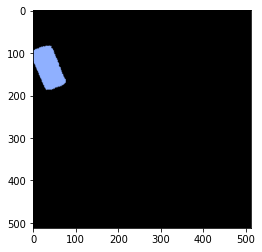

In [50]:
plt.imshow(np.transpose(train_batch["annotation_rgb"].squeeze(), (1, 2, 0)))
# print(train_batch["annotation"].shape)
# plt.imshow(Image.fromarray(np.uint8(train_batch["annotation"].squeeze()), 'L'))

## Loss Function Choice
* Firstly, the Mean Squared Error (MSE) loss was chosen since the model is learning to construct the annotation images where its values are real numbers between 0 and 1
  * However with testing, the model tended to produce outputs that were mostly black with muted grey edges even when the train loss was decreasing to values near 0. 
  * This can be explained since the ground truth annotation images contain mostly black representing "no damage" which the model exploits to achieve low MSE loss since most of the pixels are correctly encoded with "no damage", offsetting the model from caring about the relevant pixels where there are damages!
* In order to inhibit the model producing darker pixels and instead learn to detect relevant damages, I made a custom MSE loss function that adds a higher penalty to pixels that are darker (close to black) in the original annotation.
* SSIM

tensor([[0.9995]], device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.9995, device='cuda:0', grad_fn=<MeanBackward0>)


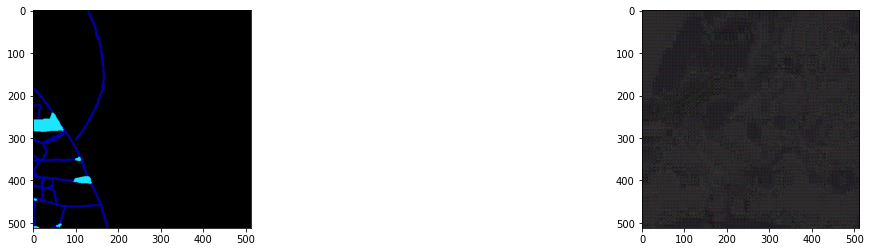

In [17]:
# Weight non-black colours highly to discount reconstructing all black images that match with most of the annotation
def weight_colours(x):
    weights = torch.full_like(x, 1)
    for i in range(len(x)):
        black = torch.all(x[i] < 0.1, dim=0)
        weights[i, :, black] = 2

    return weights

def MSELoss_WeightColours(x, y):
    return torch.mean(F.mse_loss(x, y)*weight_colours(x))


def luminance(x, y):
    mu_x, mu_y = torch.mean(x), torch.mean(y)
    return (2*mu_x*mu_y + 0.1)/(mu_x*mu_x + mu_y*mu_y + 0.1)

def contrast(x, y):
    sigma_x, sigma_y = torch.std(x), torch.std(y)
    return (2*sigma_x*sigma_y + 0.1)/(sigma_x*sigma_x + sigma_y*sigma_y + 0.1)

def structure(x, y):
    return (len(x)-1)*torch.sum((x - torch.mean(x))*(y - torch.mean(y)))

def SSIM(x, y):
    return (luminance(x, y)*contrast(x, y)*structure(x, y))


def DiceLoss(x, y, smooth=1):
    dice_losses = torch.zeros((x.shape[0]))
    for i in range(x.shape[0]):
        x_i = x[i].view(-1)
        y_i = y[i].view(-1)
        intersection = (x_i*y_i).sum()

        dice_losses[i] = (1 - ((2.*intersection + smooth)/(x_i.sum() + y_i.sum() + smooth)))

    return torch.mean(dice_losses)

# criterion = MSELoss_WeightColours
# criterion = SSIM
criterion = DiceLoss

output = train_batch["annotation_rgb"]
target = model(train_batch["image"].to(device))

plt.figure(figsize=(14,4))
ax = plt.subplot(1, 2, 1)
plt.imshow(np.clip(np.transpose(output.numpy()[0], (1, 2, 0)).astype(float), 0, 1))
ax = plt.subplot(1, 2, 2)
plt.imshow(np.clip(np.transpose(target.detach().cpu().numpy()[0], (1, 2, 0)).astype(float), 0, 1))

loss = criterion(output, target.detach().cpu())
print(loss)

## Model Loading
Auxiliary functions to load the `model_state_dict` intermittently before every epoch to update saved checkpoints.

In [12]:
def load_model(model_path, model, optimiser):
    epoch = 0
    train_loss_history, val_loss_history = [], []
    try:
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimiser.load_state_dict(checkpoint["optimiser_state_dict"])
        epoch = checkpoint["epoch"]
        train_loss_history = checkpoint["train_loss_history"]
        val_loss_history = checkpoint["val_loss_history"]
    except Exception as ex:
        print(ex)

    return epoch, train_loss_history, val_loss_history

def load_history(model_path):
    checkpoint = torch.load(model_path)
    return checkpoint["train_loss_history"], checkpoint["val_loss_history"]

### Model Hyperparameter Choices:
* Initially try 10 epochs and gradually the number to observe if model appears to be learning/improving.
* Learning rate set to 0.01 as this is the standard rate for most tasks
* Using Mean Squared Error (MSE) Loss since this involves the construction of annotations from the input image where values are between 0 and 1
* Stochastic Gradient Descent (SGD) initially tried as optimiser then will move to Adaptive ones such as Adam

In [13]:
num_epochs = 10
learning_rate = 0.01
momentum = 0.9

encoder = Encoder()
decoder = Decoder()
model = EncoderDecoder(encoder, decoder).to(device)
# model = UNet().to(device)

# Loss + Optimiser
# criterion = nn.MSELoss()
# criterion = MSELoss_WeightColours()
# criterion = SSIM
criterion = DiceLoss

optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=momentum)

# Load model if exists
model_name = f"damage-detector.pt"
if not os.path.exists(f"{root_dir}/model"):
    os.mkdir(f"{root_dir}/model")
cur_epoch, train_loss_history, val_loss_history = load_model(f"{root_dir}model/{model_name}", model, optimiser)

if len(train_loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tTrain Loss: {train_loss_history[-1]:.4f}\n\tValidation Loss: {val_loss_history[-1] if len(val_loss_history) > 0 else 0:.4f}")

damage-detector.pt
	Epoch: 10
	Train Loss: 0.0587
	Validation Loss: 0.0580


## Model Training
Functions to run train and test epochs, as well as visualise input images and model output transformations.

In [38]:
from tqdm import tqdm

def train_epoch(model, loader, criterion, optimiser):
    model.train()
    losses = []
    first_batch = None
    for i, inputs in enumerate(tqdm(loader)):
        if i == 0:
            first_batch = inputs
        out = model(inputs["image"].to(device))
        loss = criterion(out, inputs["annotation_rgb"].to(device))

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        losses.append(loss.item())

        del inputs, out
        torch.cuda.empty_cache()

    return np.mean(losses), first_batch

def test_epoch(model, loader, criterion):
    model.eval()
    losses = []
    first_batch = None
    with torch.no_grad():
        for i, inputs in enumerate(tqdm(loader)):
            if i == 0:
                first_batch = inputs
            out = model(inputs["image"].to(device))
            loss = criterion(out, inputs["annotation_rgb"].to(device))
            losses.append(loss.item())
            
            del inputs, out
    
    return np.mean(losses), first_batch

def visualise_outputs(model, batch):
    plt.figure(figsize=(14,4))
    n = 10
    for i, item in enumerate(batch["image"][:n]):
        with torch.no_grad():
            reconstructed = model(item.unsqueeze(dim=0).to(device))

        ax = plt.subplot(2, n, i+1)
        plt.imshow(np.clip(np.transpose(batch["annotation_rgb"][i].numpy(), (1, 2, 0)).astype(float), 0, 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
          ax.set_title("Actual Annotation")

        ax = plt.subplot(2, n, i+n+1)
        plt.imshow(np.clip(np.transpose(reconstructed.cpu().squeeze().numpy(), (1, 2, 0)).astype(float), 0, 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title("Predicted Annotation")

    plt.show()

visualise_outputs(model, train_batch)

In [ ]:
if TRAIN:
    for epoch in range(cur_epoch, num_epochs):
        print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
        if os.path.exists(f"{root_dir}/model/{model_name}"):
            train_loss_history, val_loss_history = load_history(f"{root_dir}/model/{model_name}")

        avg_train_loss, first_batch = train_epoch(model, train_loader, criterion, optimiser)
        print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
        visualise_outputs(model, batch=first_batch)

        torch.save({"epoch": epoch+1,
                    "model_state_dict": model.state_dict(),
                    "optimiser_state_dict": optimiser.state_dict(),
                    "train_loss_history": train_loss_history + [avg_train_loss],
                    "val_loss_history": val_loss_history},
                    f"{root_dir}/model/{model_name}")

        # VALIDATION
        avg_val_loss, first_batch = test_epoch(model, val_loader, criterion)
        print(f"\tAverage Validation Loss: {avg_val_loss:.4f}")
        visualise_outputs(model, batch=first_batch)

        model_checkpoint = torch.load(f"{root_dir}/model/{model_name}")
        model_checkpoint["val_loss_history"].append(avg_val_loss)
        torch.save(model_checkpoint, f"{root_dir}/model/{model_name}")

## Evaluation on Test

Idea is to visualise outputs and use pretrained CLIP image embeddings to evaluate the Cosine similarity between the known annotation and the model's prediction. This was because the CLIP model has been trained on millions of a wide variety of images, making it possible to provide rich representations capturing colours and their locations within the embedding itself.

tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')


C:\Users\jovin\AppData\Local\Temp/ipykernel_6552/1099990257.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,4))


tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
tensor([[1.]], device='cuda:0')
torch.Size([23])


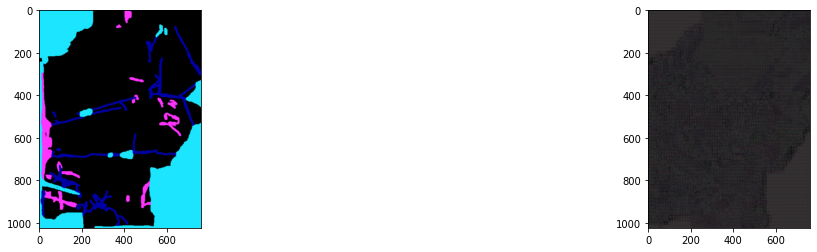

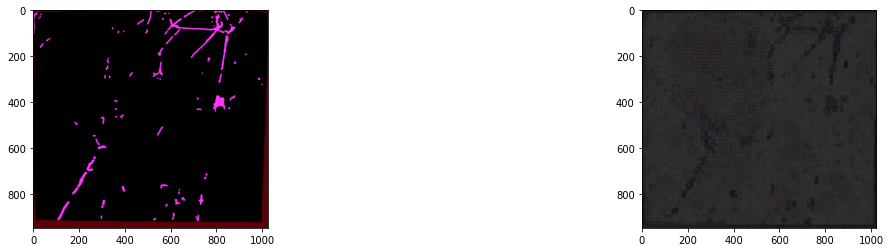

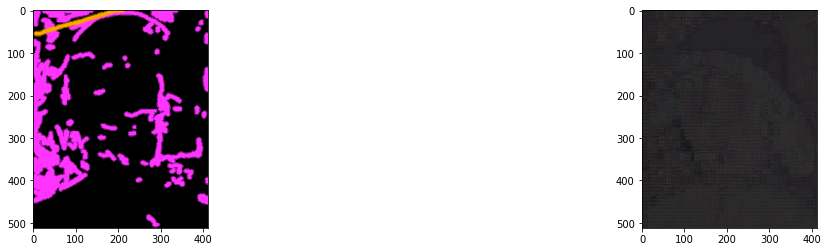

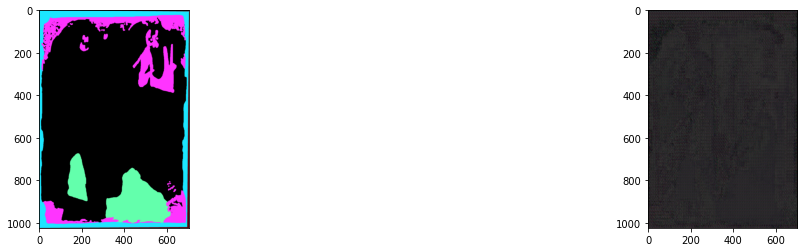

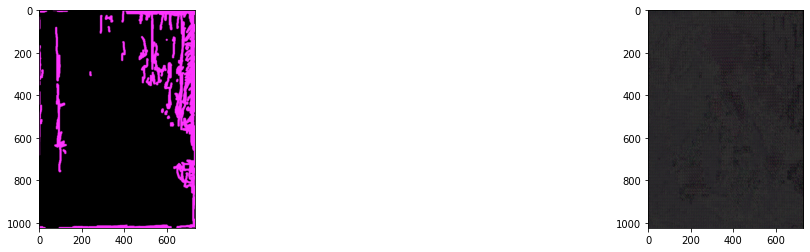

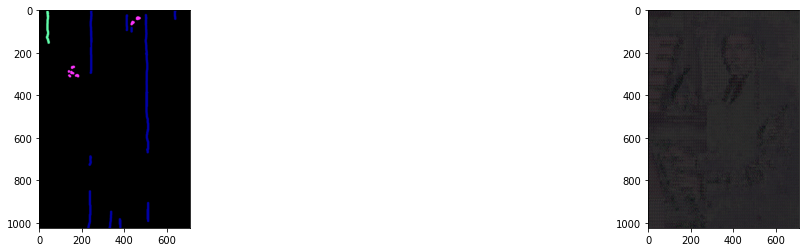

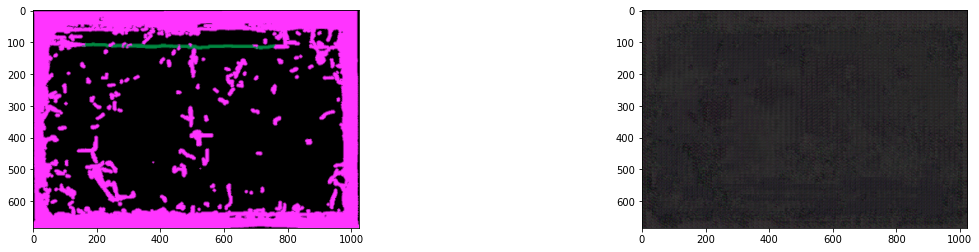

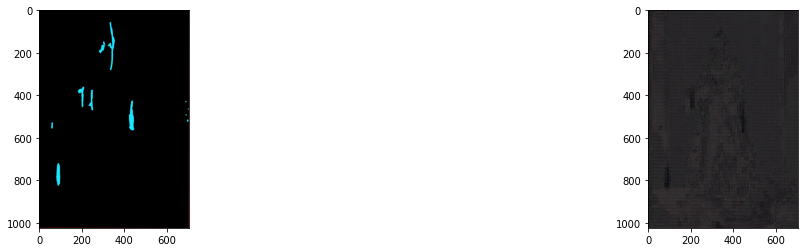

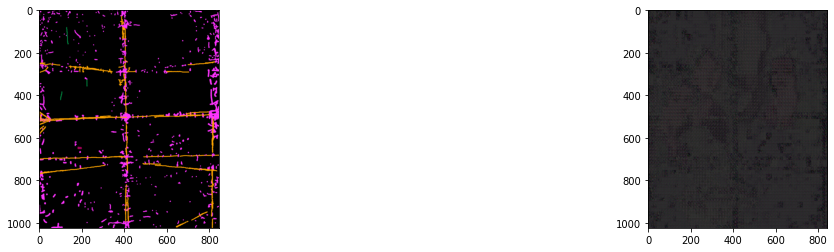

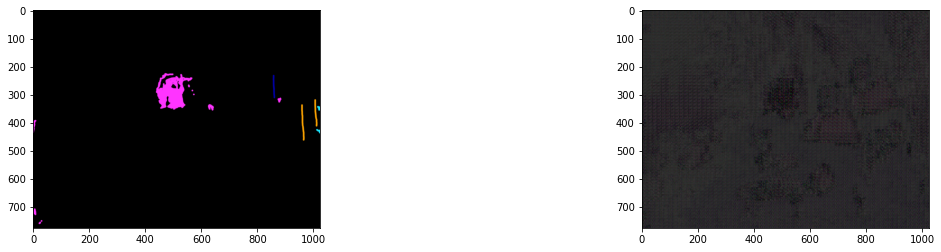

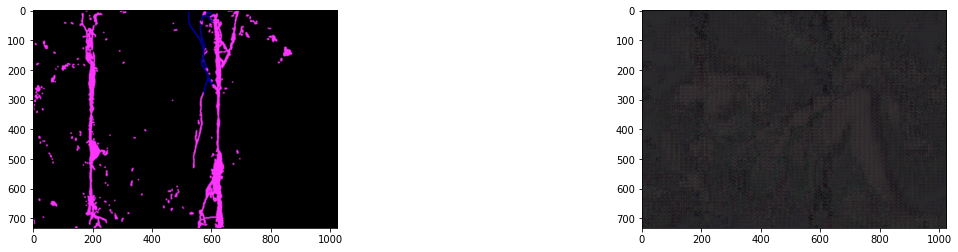

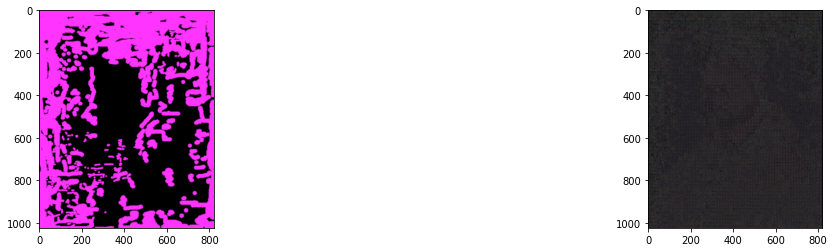

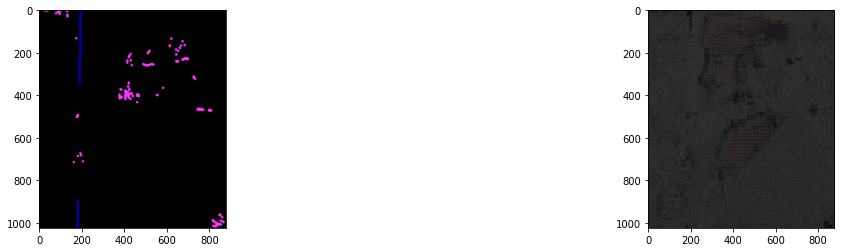

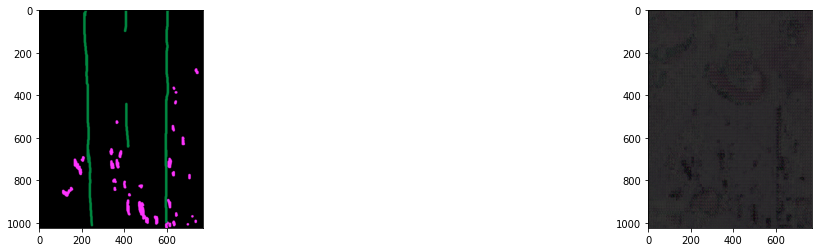

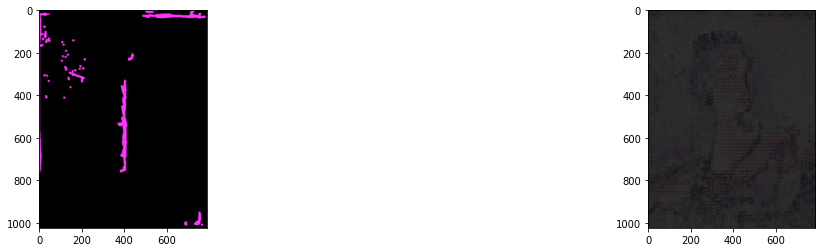

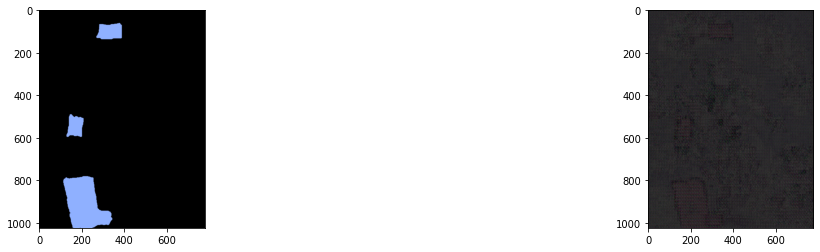

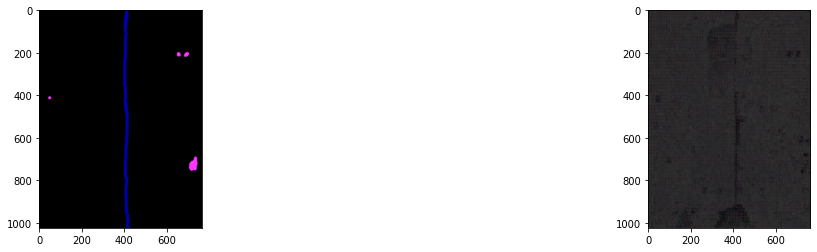

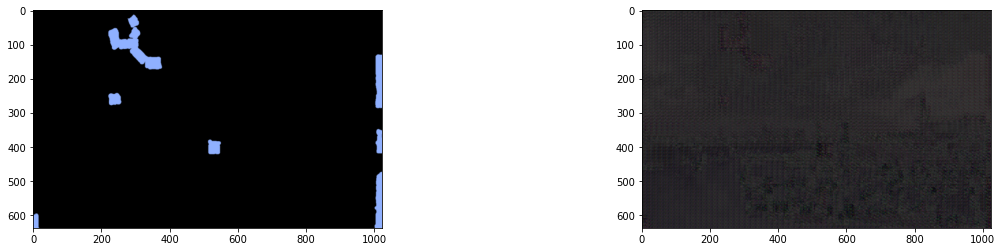

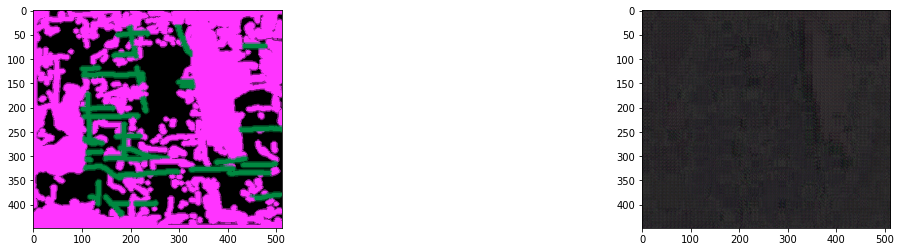

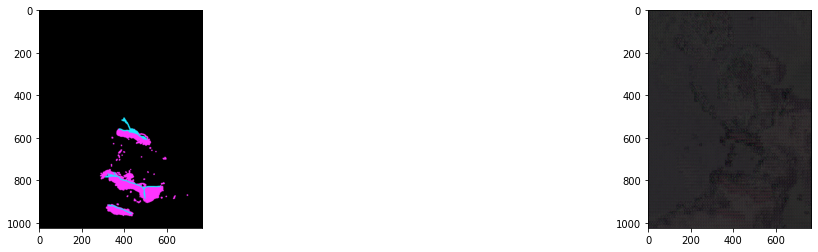

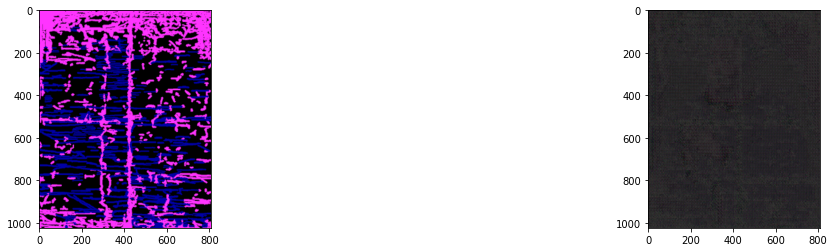

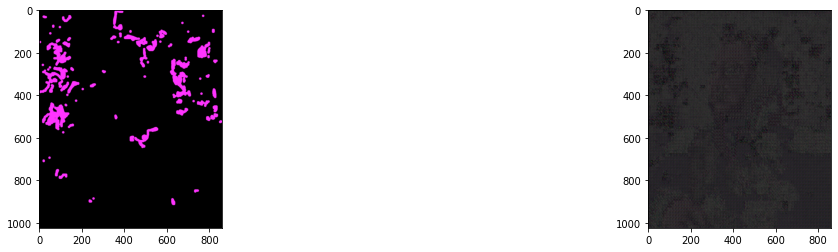

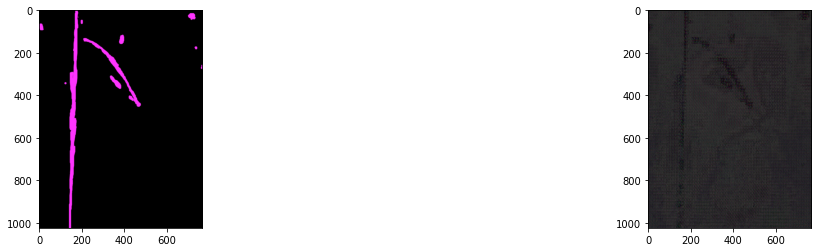

In [31]:
from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_id)
clip = CLIPModel.from_pretrained(model_id).to(device)

similarities = []
with torch.no_grad():
    for inputs in test_loader:
        outputs = inputs["annotation_rgb"]
        targets = model(inputs["image"].to(device)).detach().cpu()

        plt.figure(figsize=(10,4))
        ax = plt.subplot(1, 2, 1)
        plt.imshow(np.clip(np.transpose(outputs.numpy()[0], (1, 2, 0)).astype(float), 0, 1))
        ax = plt.subplot(1, 2, 2)
        plt.imshow(np.clip(np.transpose(targets.cpu().numpy()[0], (1, 2, 0)).astype(float), 0, 1))

        processed_outputs = processor(text=None, images=outputs.squeeze(), return_tensors="pt", padding=True)["pixel_values"].to(device)
        processed_targets = processor(text=None, images=targets.squeeze(), return_tensors="pt", padding=True)["pixel_values"].to(device)

        output_embs = clip.get_image_features(pixel_values=processed_outputs)
        target_embs = clip.get_image_features(pixel_values=processed_targets)

        scores = torch.softmax(torch.bmm(output_embs.unsqueeze(1), target_embs[..., None]).squeeze(1), dim=-1)
        print(scores)
        similarities.append(scores.squeeze())

similarities = torch.stack(similarities)
print(similarities.shape)

# Git Configuration

In [ ]:
# Install Git
!apt-get install -y git

# Configure Git
!git config --global user.email "your@email.com"
!git config --global user.name "Your Name"

# Clone your GitHub repository
!git clone https://github.com/your-username/your-repo.git

# TODO: MOVE MODEL OUT OF DRIVE

# Commit and push changes to GitHub
%cd /content/your-repo
!git add .
!git commit -m f"Model {model_name} | Epoch {cur_epoch}"
!git push origin master